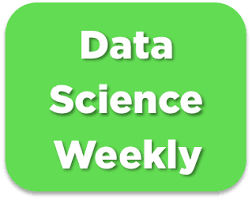

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [20]:

from sklearn import tree
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, RocCurveDisplay

import seaborn as sb
import squarify
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3",
                     "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"  # to be replaced by "iframe" if working on JULIE


# Read file with labels

In [21]:
df = pd.read_csv('data/conversion_data_train.csv')
print('Set with labels (our train+test) :', df.shape)

Set with labels (our train+test) : (284580, 6)


In [22]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

<AxesSubplot: title={'center': 'Age distribution'}, ylabel='Frequency'>

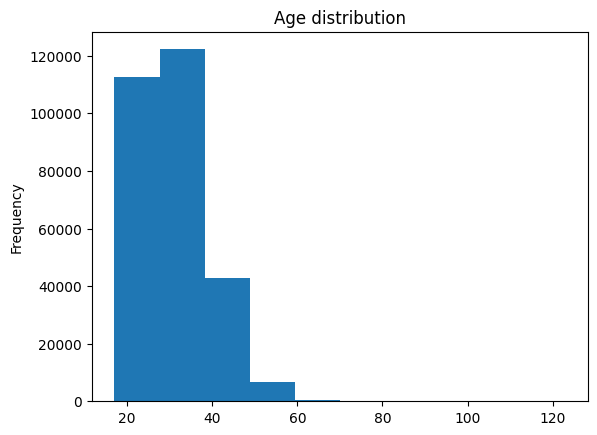

In [23]:
df["age"].plot(title="Age distribution", ylabel="Population", xlabel="Age", kind="hist")

<AxesSubplot: title={'center': 'Age distribution'}, ylabel='Frequency'>

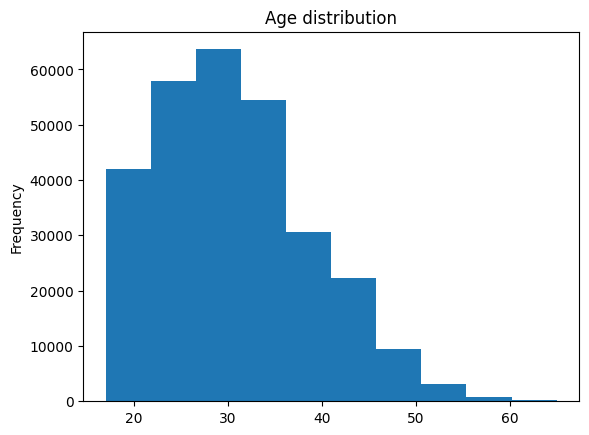

In [24]:
age_outliers = df["age"] > 65
df = df[~age_outliers]
df["age"].plot(title="Age distribution", ylabel="Population", xlabel="Age", kind="hist")

Text(0.5, 1.0, 'Distribution of countries among the dataset en %')

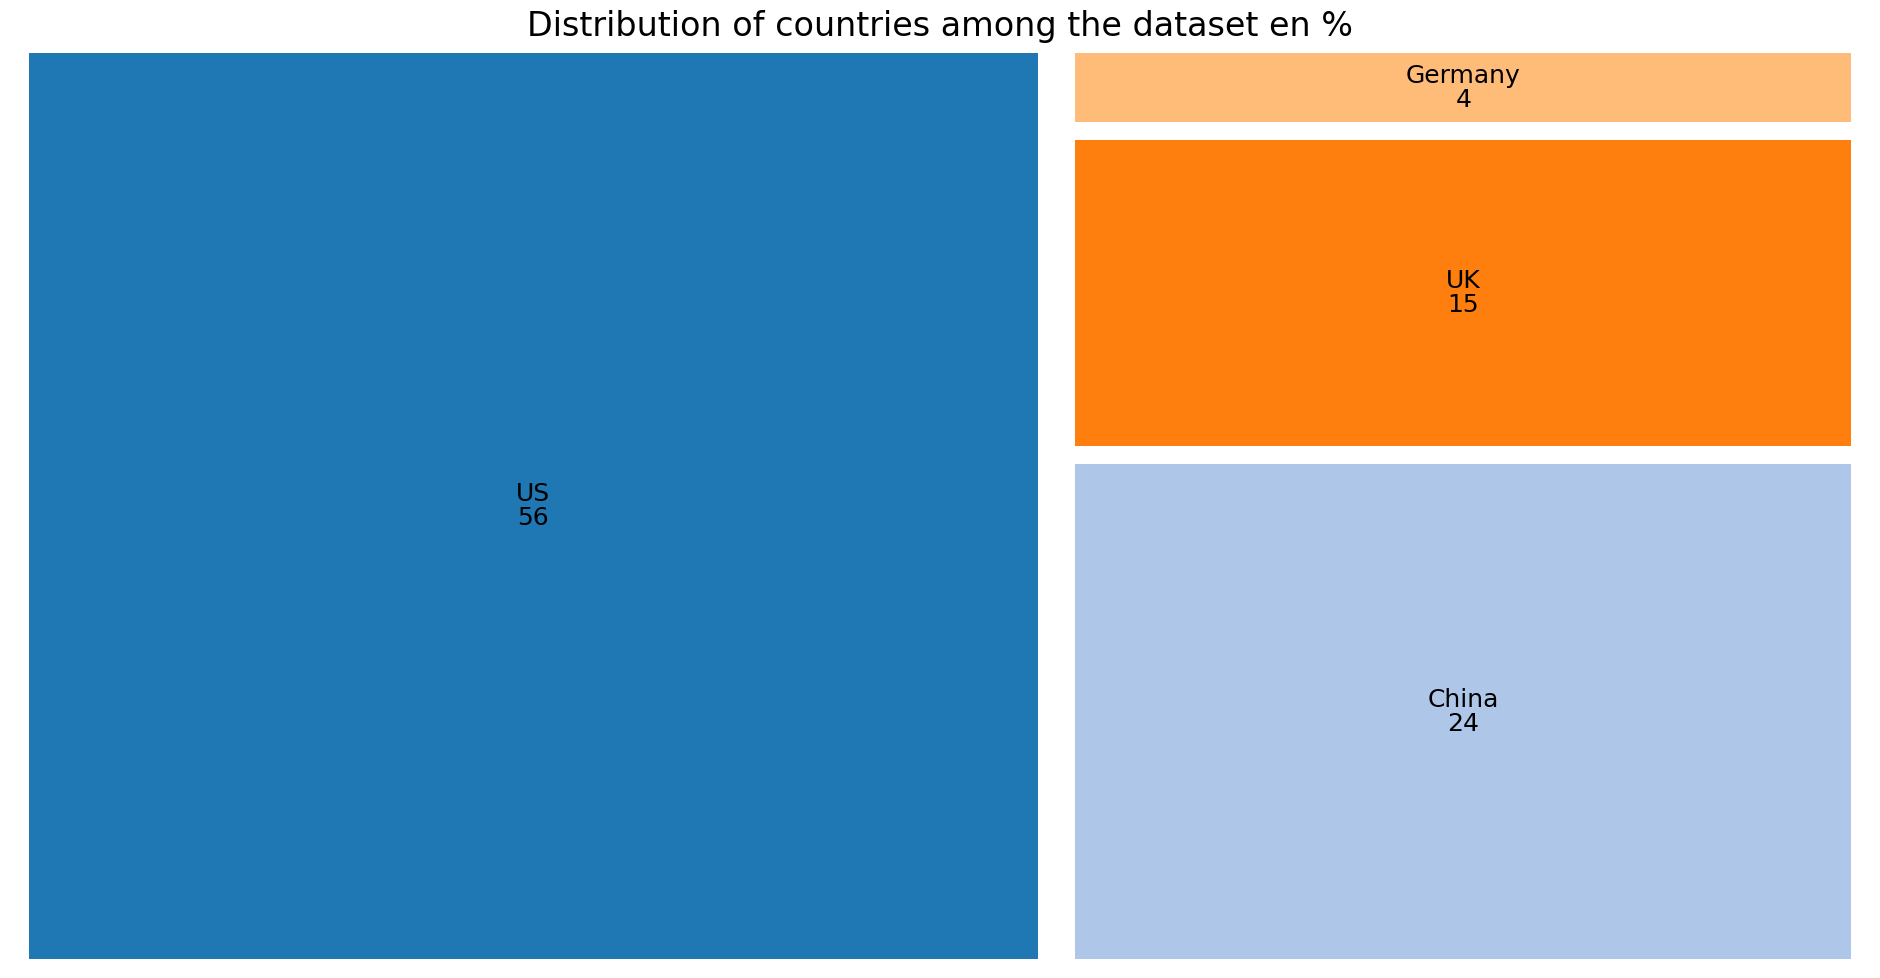

In [25]:
# create a plot figure with figsize
plt.figure(figsize=(24, 12))
# we don't require the axis values so lets remove it
plt.axis("off")
axis = squarify.plot(df["country"].value_counts(),
                     label=df["country"].value_counts().index,
                     color=sb.color_palette("tab20", len(df["country"].value_counts())),
                     value=(df["country"].value_counts()*100) // len(df["country"]),
                     pad=1,
                     text_kwargs={'fontsize': 18})
axis.set_title("Distribution of countries among the dataset en %", fontsize=24)


In [26]:
df['EUR'] = df['country'].map(lambda x: 'Yes' if x != 'US' and x!= 'China' else 'No')

Text(0.5, 1.0, 'Distribution of sources among the dataset en %')

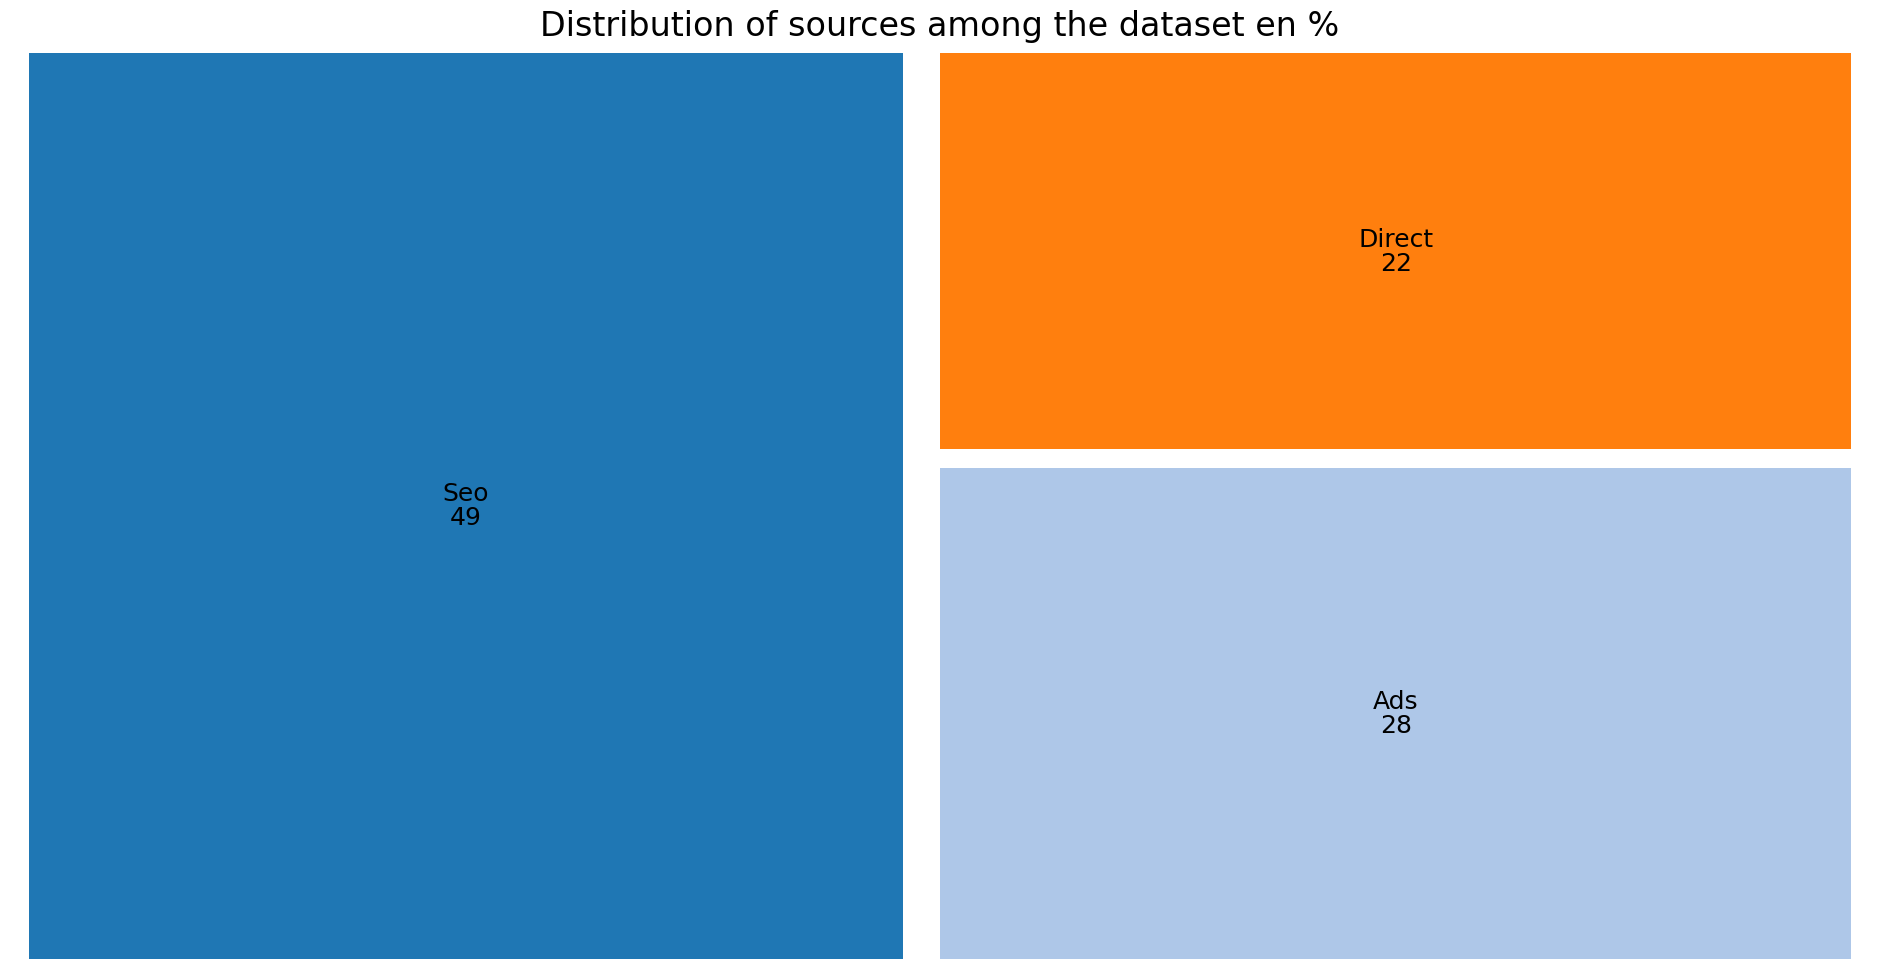

In [27]:
# create a plot figure with figsize
plt.figure(figsize=(24, 12))
# we don't require the axis values so lets remove it
plt.axis("off")
axis = squarify.plot(df["source"].value_counts(),
                     label=df["source"].value_counts().index,
                     color=sb.color_palette("tab20", len(df["source"].value_counts())),
                     value = (df["source"].value_counts()*100) // len(df["source"]),
                     pad=1,
                     text_kwargs={'fontsize': 18})
axis.set_title("Distribution of sources among the dataset en %", fontsize=24)


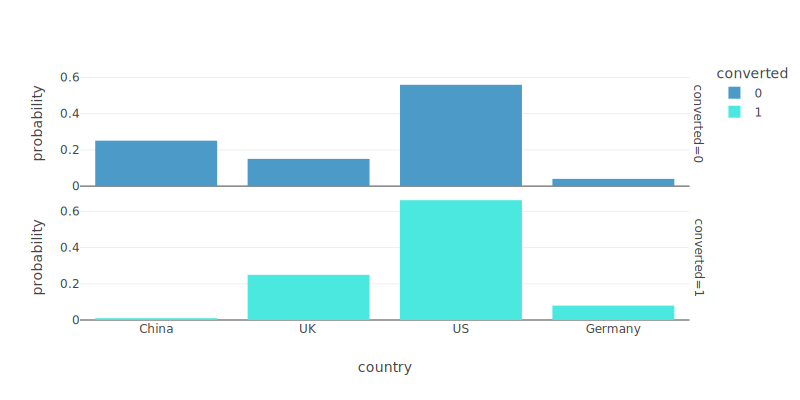

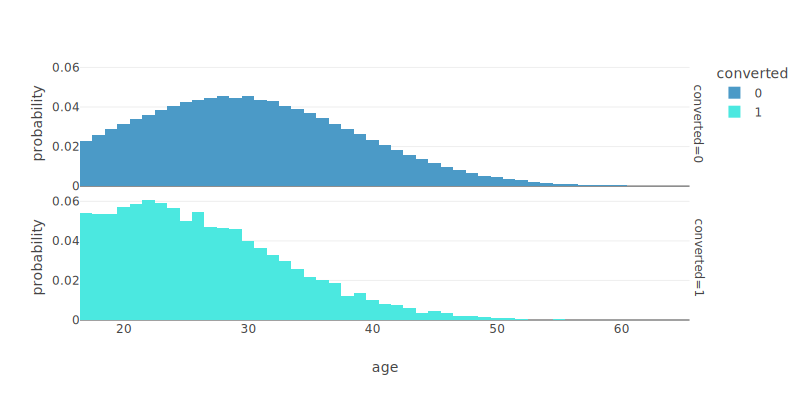

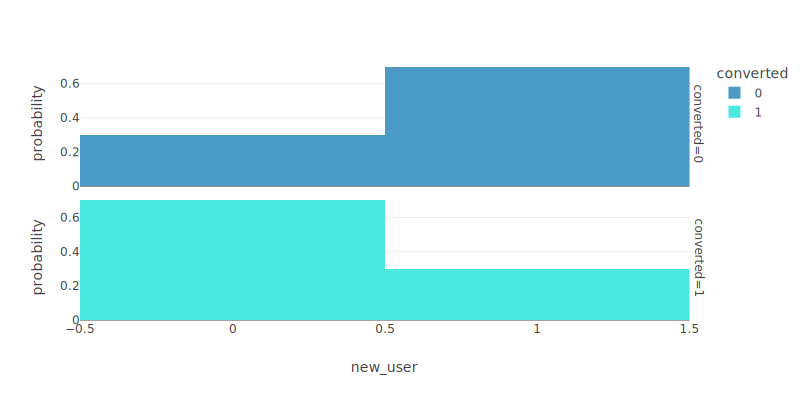

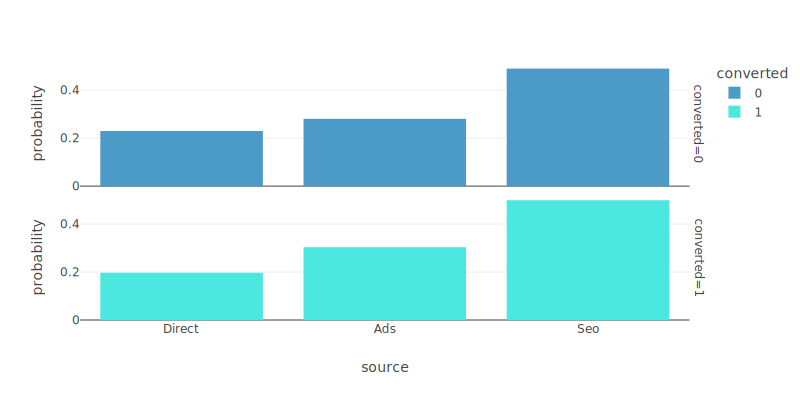

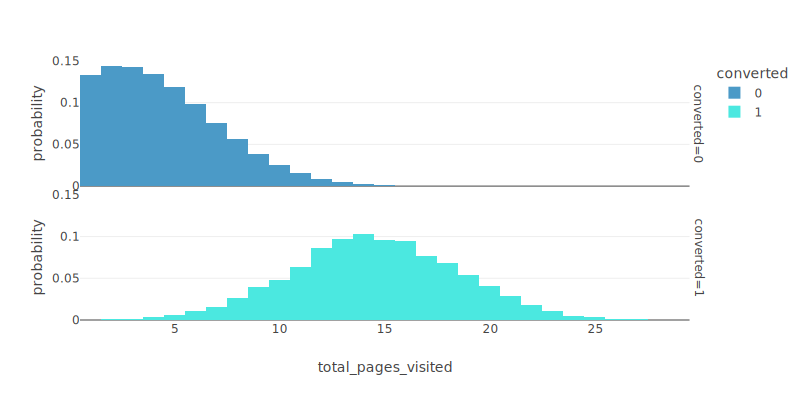

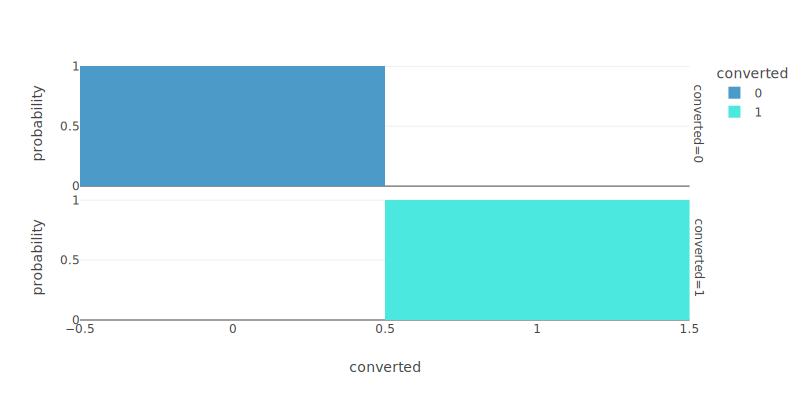

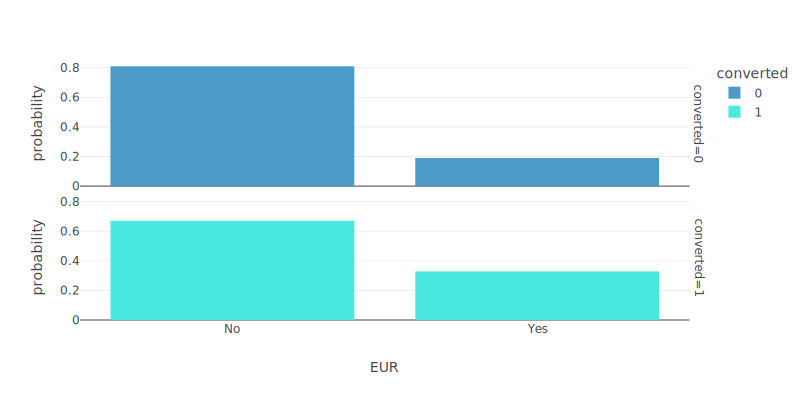

In [28]:
for feature in list(df.columns):
    fig = px.histogram(df, feature, color = 'converted', facet_row = 'converted', histnorm = 'probability',width=800, height=400)
    fig.show()

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [29]:
features_list = ['age', 'new_user', 'total_pages_visited','country', 'source','EUR']
target_name = 'converted'

X = df.loc[:, features_list]
Y = df.loc[:, target_name]

print('Explanatory variables : ', X.columns)

Explanatory variables :  Index(['age', 'new_user', 'total_pages_visited', 'country', 'source', 'EUR'], dtype='object')


In [30]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")

Dividing into train and test sets...
...Done.


## Training pipeline

In [31]:
# Create pipeline for numeric features
numeric_features = X.select_dtypes([np.number]).columns # Automatically detect positions of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = X.select_dtypes("object").columns # Automatically detect positions of categorical columns
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train) # Preprocessing influenceur
X_test = preprocessor.transform(X_test) # Preprocessing copieur

print(f'numeric_features : {numeric_features}')
print(f'categorical_features : {categorical_features}')

numeric_features : Index(['age', 'new_user', 'total_pages_visited'], dtype='object')
categorical_features : Index(['country', 'source', 'EUR'], dtype='object')


# Training Model

Grid Search For Random Forest Model

In [32]:
'''model = RandomForestClassifier()
params = {
    'max_depth': [4,6,8,10,12],
    'min_samples_split': [5,10,15,20,25],
    'n_estimators': [25,50,75,100,125]
}

gridsearch = GridSearchCV(model, param_grid = params, n_jobs=-1, cv = 5,scoring='f1') 
gridsearch.fit(X_train, Y_train)

print(f'best estimator : {gridsearch.best_estimator_}')
print(f'best score : {gridsearch.best_score_}')
print(f'best parameters : {gridsearch.best_params_}')
'''


"model = RandomForestClassifier()\nparams = {\n    'max_depth': [4,6,8,10,12],\n    'min_samples_split': [5,10,15,20,25],\n    'n_estimators': [25,50,75,100,125]\n}\n\ngridsearch = GridSearchCV(model, param_grid = params, n_jobs=-1, cv = 5,scoring='f1') \ngridsearch.fit(X_train, Y_train)\n\nprint(f'best estimator : {gridsearch.best_estimator_}')\nprint(f'best score : {gridsearch.best_score_}')\nprint(f'best parameters : {gridsearch.best_params_}')\n"

In [33]:
forest_clf = RandomForestClassifier(max_depth= 10, min_samples_split= 15, n_estimators= 75)
forest_clf.fit(X_train, Y_train)

train_pred = forest_clf.predict(X_train)
Y_pred = forest_clf.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_pred))
print(f'accuracy : {accuracy_score(Y_test, Y_pred)}')

f1-score on train set :  0.7779336138382421
f1-score on test set :  0.7575030012004801
accuracy : 0.9858026426764127


# Features Importance

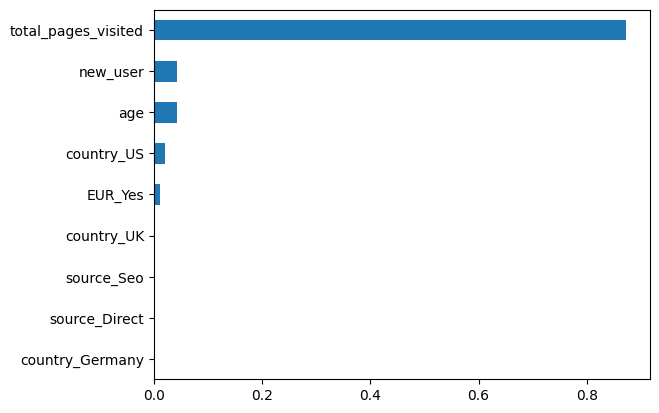

In [34]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
feat_importances = pd.Series(forest_clf.feature_importances_, index=col_names)
feat_importances.sort_values().plot(kind='barh')
plt.show()

# Matrix Confusion

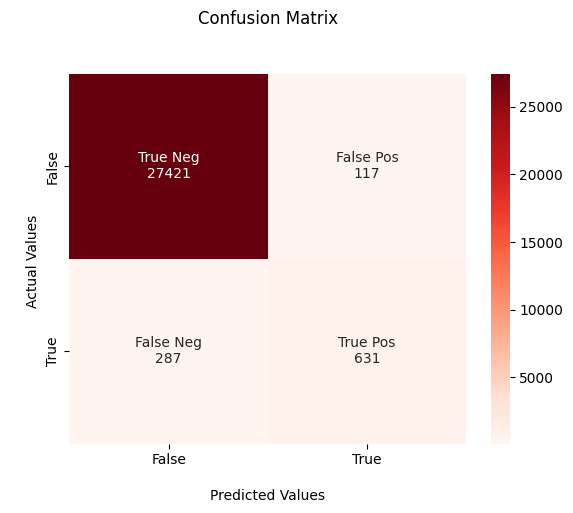

In [35]:
matrix_confusion = confusion_matrix(Y_test, Y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix_confusion.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sb.heatmap(matrix_confusion, annot=labels, fmt='', cmap='Reds')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('\nActual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# ROC Curves

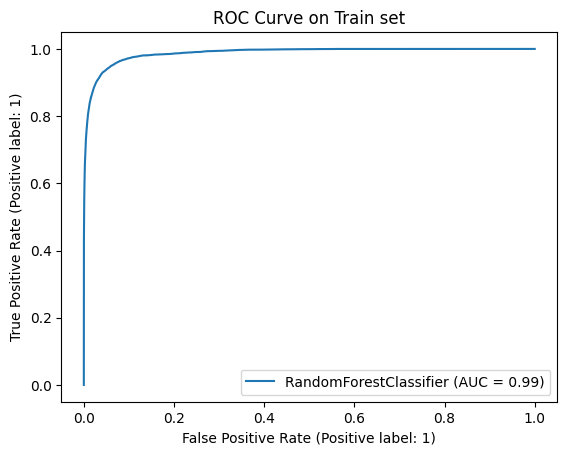

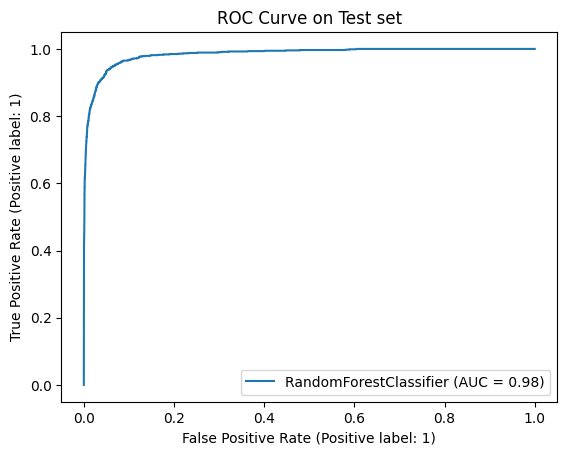

In [36]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(forest_clf, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(forest_clf, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

# Best classifier on all data and predictions on X_without_labels

In [37]:
# Read data without labels
data_without_labels = pd.read_csv('data/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Add the EUR column here as well
data_without_labels['EUR'] = data_without_labels['country'].map(lambda x: 'Yes' if x != 'US' and x!= 'China' else 'No')
X_without_labels = data_without_labels.loc[:, features_list]
print(data_without_labels.head())
# same preprocessing on X_without_labels
X_without_labels = preprocessor.transform(X_without_labels)

Prediction set (without labels) : (31620, 5)
  country  age  new_user  source  total_pages_visited  EUR
0      UK   28         0     Seo                   16  Yes
1      UK   22         1  Direct                    5  Yes
2   China   32         1     Seo                    1   No
3      US   32         1     Ads                    6   No
4   China   25         0     Seo                    3   No


In [38]:
# Make predictions and dump to file according to challenge requirements

data = {
    'converted': forest_clf.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('results/conversion_data_test_predictions_HICHAM.csv', index=False)